**DESCRIZIONE DEL DATASET**

Il dataset Chest X-Ray Images (Pneumonia) è una raccolta di immagini radiografiche toraciche (in formato JPEG) utilizzate per il riconoscimento automatico di polmonite tramite tecniche di apprendimento profondo. È stato originariamente pubblicato da [Kermany et al., 2018] come parte di uno studio clinico volto a migliorare la diagnosi automatica di malattie polmonari.

Il dataset è suddiviso in tre sottoinsiemi principali:

1.   Train: immagini utilizzate per l’addestramento del modello
2.   Validation: immagini per la validazione durante l’addestramento
3.   Test: immagini per la valutazione finale

Ciascun sottoinsieme è ulteriormente suddiviso in due classi:


*   NORMAL: radiografie toraciche senza segni di infezione
*   PNEUMONIA: radiografie con evidenti segni di polmonite (può includere casi virali e batterici)

**Dimensioni**

Oltre 5.800 immagini totali
Immagini a scala di grigi, risoluzioni variabili
Bilanciamento delle classi non uniforme: la classe "PNEUMONIA" è più rappresentata rispetto a "NORMAL"

**Obiettivo**

L’obiettivo è costruire un modello di classificazione binaria in grado di distinguere tra immagini normali e affette da polmonite, contribuendo a un processo diagnostico più rapido ed efficace.

**Fonte**

Pubblicato su: Kaggle - Chest X-Ray Images (Pneumonia)
Autori: Daniel Kermany et al.
Licenza: Open dataset per uso educativo e di ricerca

In [4]:
# Librerie di sistema
import os
import zipfile
import random
import shutil

# Manipolazione numerica e dati
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Metriche di valutazione
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Deep learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
# Imposta un seed comune
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Dati
data = {
    "Set": ["Train", "Validation", "Test"],
    "NORMAL": [1341, 8, 234],
    "PNEUMONIA": [3875, 8, 390],
    "Totale": [5216, 16, 624]
}

# Crea DataFrame
df = pd.DataFrame(data)

# Mostra la tabella
df.style.set_caption("Suddivisione del Dataset Chest X-Ray Pneumonia")


,Set,NORMAL,PNEUMONIA,Totale
0,Train,1341,3875,5216
1,Validation,8,8,16
2,Test,234,390,624


Nel dataset originale "Chest X-Ray Pneumonia", il set di validazione (val/) contiene solo 16 immagini (8 per ciascuna classe), una quantità statisticamente insufficiente per monitorare efficacemente l’andamento dell’apprendimento del modello. Per garantire una valutazione più affidabile durante il training, si è scelto di ignorare questo sottoinsieme e di effettuare una nuova suddivisione interna del training set, riservando il 20% delle immagini alla validazione tramite il parametro validation_split di ImageDataGenerator. In questo modo, si ottiene una distribuzione più rappresentativa e bilanciata dei dati per il monitoraggio delle prestazioni, mentre il set test/ viene conservato per la valutazione finale e indipendente del modello. Questa strategia è coerente con le buone pratiche nel campo dell’apprendimento automatico supervisionato.

In [7]:
# Chest X-Ray Pneumonia Classification (CNN) - Progetto DL (Subset Ridotto)
# Scarica e prepara un sottoinsieme del dataset da Kaggle

from google.colab import files

# Caricamento kaggle.json per API accesso (se non già fatto)
from google.colab import files
print(" Carica il tuo kaggle.json per usare le API Kaggle")
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Scarica dataset completo
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


 Carica il tuo kaggle.json per usare le API Kaggle


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:15<00:00, 205MB/s]
100% 2.29G/2.29G [00:15<00:00, 161MB/s]


In [8]:
# Estrai le immagini
with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/chest_xray_full")

In [9]:
# Percorsi dataset
train_dir = "/content/chest_xray_full/chest_xray/train"
test_dir = "/content/chest_xray_full/chest_xray/test"
val_dir = "/content/chest_xray_full/chest_xray/val"



 Classe: NORMAL


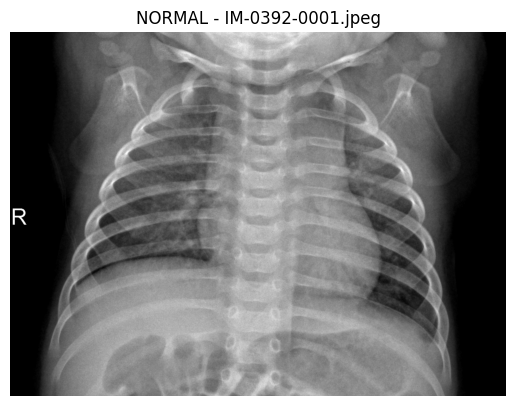

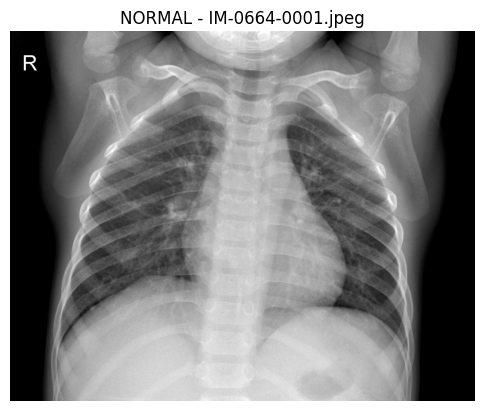

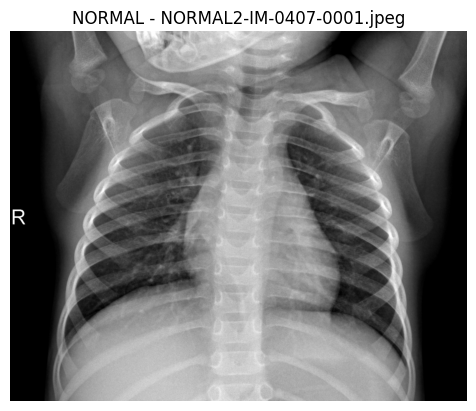


 Classe: PNEUMONIA


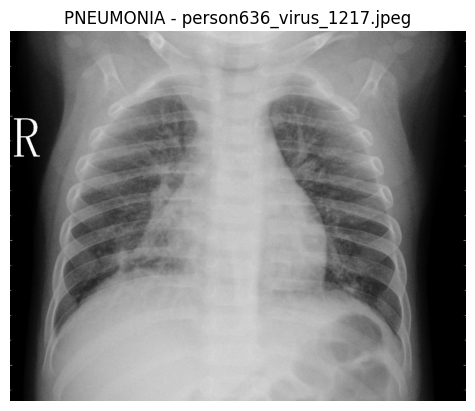

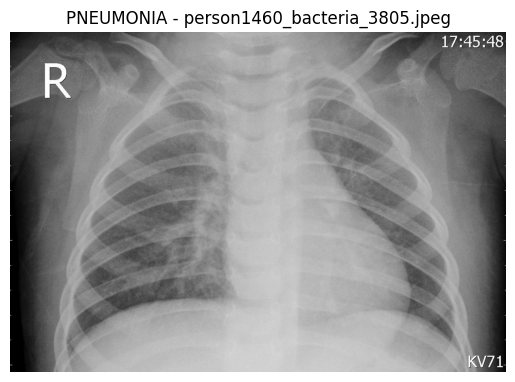

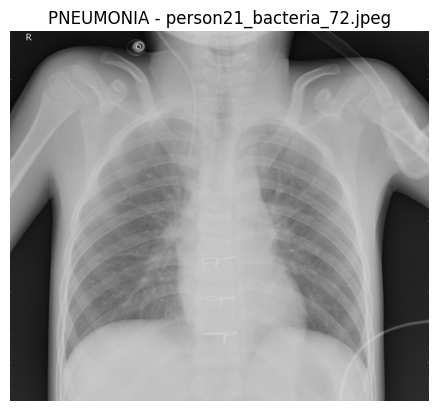

In [10]:
from PIL import Image

# Visualizza immagini campione per ciascuna classe
classes = ['NORMAL', 'PNEUMONIA']
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    sample_imgs = random.sample(os.listdir(cls_path), 3)
    print(f"\n Classe: {cls}")
    for img_name in sample_imgs:
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f"{cls} - {img_name}")
        plt.axis('off')
        plt.show()



In [11]:
raw_datagen = ImageDataGenerator()

# Ottieni un batch da una directory qualsiasi
raw_gen = raw_datagen.flow_from_directory(
    '/content/chest_xray_full/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

# Itera su un batch
for image_batch, labels_batch in raw_gen:
    print('Min value:', np.min(image_batch))
    print('Max value:', np.max(image_batch))
    break

Found 5216 images belonging to 2 classes.
Min value: 0.0
Max value: 255.0


In [12]:
# ImageDataGenerator

img_size = (150, 150)
batch_size = 32

# Usa validation_split per dividere il training set in train e validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
for image_batch, labels_batch in train_gen:
  print('Min value: ', np.min(image_batch))
  print('Max value: ', np.max(image_batch))
  break

Min value:  0.0
Max value:  1.0


In [14]:
def count_images_per_class(base_path):
    class_counts = {}
    for cls in os.listdir(base_path):
        cls_path = os.path.join(base_path, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')])
            class_counts[cls] = count
    return class_counts

# Percorsi
print("Train Set:")
train_counts = count_images_per_class(train_dir)
print(train_counts)

print("\n Validation Set:")
val_counts = count_images_per_class(val_dir)
print(val_counts)

print("\n Test Set:")
test_counts = count_images_per_class(test_dir)
print(test_counts)

Train Set:
{'PNEUMONIA': 3875, 'NORMAL': 1341}

 Validation Set:
{'PNEUMONIA': 8, 'NORMAL': 8}

 Test Set:
{'PNEUMONIA': 390, 'NORMAL': 234}


In [15]:
# 0: NORMAL, 1: PNEUMONIA
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=[0]*1341 + [1]*3875
)

class_weight = {0: class_weights[0], 1: class_weights[1]}
print(" Class weights:", class_weight)

 Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [16]:
# CNN MODEL
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

**Descrizione del Modello CNN Model1**

Il modello Model1 è una rete neurale convoluzionale (CNN) progettata per eseguire una classificazione binaria su immagini in scala di grigi di dimensioni 150×150. La rete inizia con un layer convoluzionale Conv2D con 32 filtri 3×3 e funzione di attivazione ReLU, seguito da un layer di max pooling per ridurre la dimensionalità. Questa combinazione è ripetuta una seconda volta, aumentando a 64 il numero di filtri convoluzionali. Successivamente, la mappa di attivazione viene appiattita tramite un layer Flatten, e passata a un layer denso (Dense) con 128 neuroni ReLU, seguito da Dropout(0.5) per mitigare l’overfitting. L’output layer utilizza una singola unità con attivazione sigmoide, adatta alla classificazione binaria. Il modello è compilato con l’ottimizzatore adam, la funzione di perdita binary_crossentropy e la metrica di accuratezza (accuracy), configurazione adatta a task di classificazione binaria come la diagnosi tra immagini normali e affette da polmonite.

In [21]:
history1 = model1.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 260ms/step - accuracy: 0.9966 - loss: 0.0131 - val_accuracy: 0.9616 - val_loss: 0.1491
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 0.9636 - val_loss: 0.1356
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.9674 - val_loss: 0.1336
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - accuracy: 0.9973 - loss: 0.0086 - val_accuracy: 0.9684 - val_loss: 0.1357
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9703 - val_loss: 0.1776
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.9980 - loss: 0.0054 - val_accuracy: 0.9645 - val_loss: 0.1653
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.9983 - loss: 0.0046 - val_accuracy: 0.9597 - val_loss: 0.1556
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9961 - loss: 0

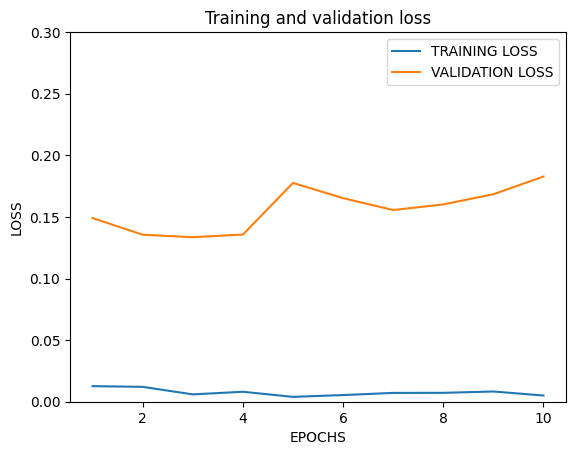

In [33]:
history_dict1 = history1.history
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']
epochs1 = range(1, len(loss1) + 1)

plt.plot(epochs1, loss1, label = 'TRAINING LOSS')
plt.plot(epochs1, val_loss1, label = 'VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('Training and validation loss')
plt.ylim(0, 0.3)
plt.legend()

plt.show()

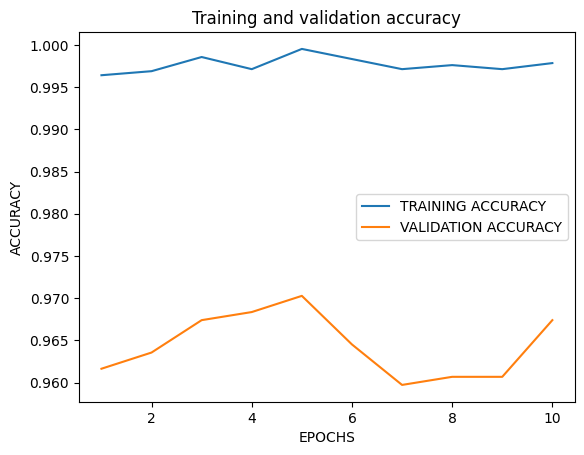

In [32]:
acc1 = history_dict1['accuracy']
val_acc1 = history_dict1['val_accuracy']
plt.plot(epochs1, acc1, label='TRAINING ACCURACY')
plt.plot(epochs1, val_acc1, label = 'VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [25]:
# Valutazione finale sul test set del Model 1
test_loss1, test_acc1 = model1.evaluate(test_gen)
print(f"\n📊 Risultati sul test set:")
print(f"Loss: {test_loss1:.4f}")
print(f"Accuracy: {test_acc1:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7018 - loss: 3.6600

📊 Risultati sul test set:
Loss: 3.3635
Accuracy: 0.7163


Il modello CNN Model1 è stato addestrato per 10 epoche con una suddivisione del dataset in training (80%) e validation (20%) ed ha evidenziato un comportamento estremamente performante durante la fase di training, raggiungendo un’accuracy di addestramento prossima al 100% (99.8%) già entro le prime epoche. Anche l’accuratezza di validazione si è mantenuta elevata, stabilizzandosi attorno al 96–97%, con una loss di validazione contenuta (~0.15). Tuttavia, nonostante l’apparente ottima generalizzazione durante il training, l’accuratezza sul test set si è ridotta al 71.63%, con una loss piuttosto alta (≈ 3.36).

L’analisi dei grafici di loss mostra una divergenza crescente tra training loss e validation loss a partire dalla quinta epoca: la loss sul training set continua a calare fino a valori prossimi allo zero, mentre quella di validazione comincia a salire, suggerendo un inizio di overfitting. Questo fenomeno è ulteriormente confermato dal fatto che, sebbene la rete memorizzi molto bene i dati di addestramento, non riesce a replicare le stesse performance sui dati non visti, come dimostrato dai risultati sul test set.

In sintesi, il modello mostra un apprendimento eccessivo sul training set e una generalizzazione subottimale, evidenziando la necessità di strategie di regolarizzazione aggiuntive o di una semplificazione architetturale per ottenere un modello più robusto e meno incline all’overfitting.

Nel corso dell’analisi preliminare del dataset Chest X-Ray Pneumonia, è stata effettuata una valutazione approfondita del bilanciamento delle classi. È emerso che il training set presenta un marcato squilibrio: la classe PNEUMONIA è quasi tre volte più rappresentata rispetto alla classe NORMAL (3875 contro 1341 immagini). Tale asimmetria può compromettere la capacità del modello di generalizzare correttamente, portandolo a favorire la classe maggioritaria. Per affrontare questa criticità, durante la fase di addestramento della rete neurale convoluzionale (CNN), si introduce una penalizzazione tramite il parametro class_weight. Questo accorgimento permette di bilanciare il contributo delle due classi nella funzione di costo, migliorando la sensibilità e l’equità della classificazione anche nei confronti della classe minoritaria.

In [17]:
history1 = model1.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.8098 - loss: 0.4164 - val_accuracy: 0.9453 - val_loss: 0.1588
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9544 - loss: 0.1275 - val_accuracy: 0.9616 - val_loss: 0.1062
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.9681 - loss: 0.0893 - val_accuracy: 0.9607 - val_loss: 0.1153
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.9789 - loss: 0.0604 - val_accuracy: 0.9549 - val_loss: 0.1349
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.9737 - loss: 0.0736 - val_accuracy: 0.9559 - val_loss: 0.1316
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - accuracy: 0.9822 - loss: 0.0475 - val_accuracy: 0.9530 - val_loss: 0.1511
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step - accuracy: 0.9869 - loss: 0.0390 - val_accuracy: 0.9655 - val_loss: 0.1237
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 272ms/step - accuracy: 0.9893 - loss: 0

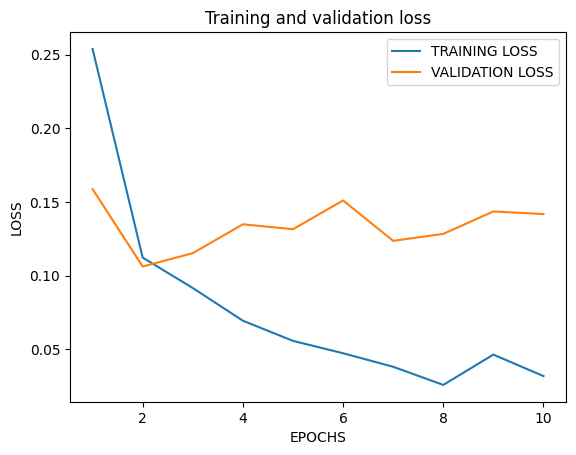

In [18]:
history_dict1 = history1.history
loss1 = history_dict1['loss']
val_loss1 = history_dict1['val_loss']
epochs1 = range(1, len(loss1) + 1)

plt.plot(epochs1, loss1, label = 'TRAINING LOSS')
plt.plot(epochs1, val_loss1, label = 'VALIDATION LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('Training and validation loss')
plt.legend()

plt.show()

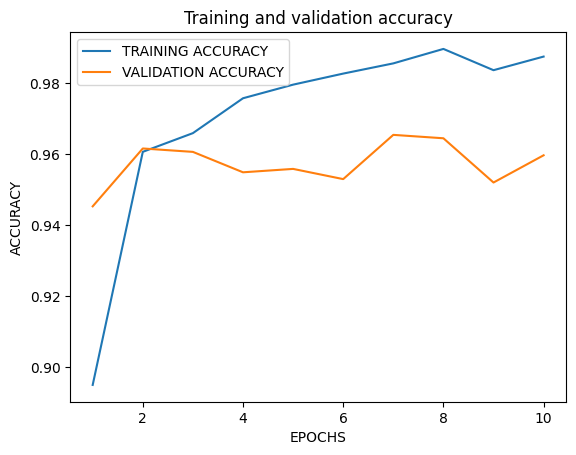

In [19]:
acc1 = history_dict1['accuracy']
val_acc1 = history_dict1['val_accuracy']
plt.plot(epochs1, acc1, label='TRAINING ACCURACY')
plt.plot(epochs1, val_acc1, label = 'VALIDATION ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [20]:
# Valutazione finale sul test set del Model 1
test_loss1, test_acc1 = model1.evaluate(test_gen)
print(f"\n📊 Risultati sul test set:")
print(f"Loss: {test_loss1:.4f}")
print(f"Accuracy: {test_acc1:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.7650 - loss: 1.5055

📊 Risultati sul test set:
Loss: 1.7006
Accuracy: 0.7500


Dopo aver rilevato un evidente sbilanciamento tra le classi nel dataset di training, il modello è stato riaddestrato introducendo una penalizzazione tramite class_weight. L’obiettivo era ridurre il bias verso la classe predominante (PNEUMONIA) e migliorare la capacità del modello di riconoscere correttamente anche la classe minoritaria (NORMAL).

I risultati ottenuti sono stati positivi: durante l’addestramento, il modello ha raggiunto una accuracy di training del 98.5%, mentre l’accuracy di validazione si è mantenuta stabile intorno al 95–96%, evidenziando una buona generalizzazione. I grafici delle metriche mostrano un andamento coerente delle curve di loss, con una differenza contenuta tra training e validation loss (entrambe comprese tra 0.03 e 0.15), a indicare un rischio di overfitting significativamente ridotto rispetto alla versione precedente del modello.

L’accuratezza finale sul test set è salita al 75.00%, con una loss pari a 1.70, mostrando un miglioramento netto rispetto all’addestramento senza bilanciamento. Questo suggerisce che l’uso del class_weight ha avuto un impatto concreto nella correzione dello sbilanciamento, favorendo una classificazione più equa tra le due classi.

In sintesi, il modello ottimizzato con penalizzazione si è dimostrato più robusto e bilanciato, ottenendo prestazioni migliorate sul test set pur mantenendo un’elevata accuratezza sui dati di validazione.


In [34]:
# Data augmentation sul training set
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_gen_aug = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_gen_aug = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [35]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),  # Dropout più alto

    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,710,913 (40.86 MB)

 Trainable params: 10,710,465 (40.86 MB)

 Non-trainable params: 448 (1.75 KB)

**Descrizione del modello CNN Model 2**

Il Model 2 CNN è composto da tre blocchi principali: ciascun blocco include un layer convoluzionale (Conv2D), seguito da una normalizzazione del batch (BatchNormalization) e da una sottocampionatura tramite MaxPooling2D. I layer convoluzionali impiegano rispettivamente 32, 64 e 128 filtri con kernel di dimensione 3×3. I blocchi convoluzionali sono seguiti da un layer Flatten, che trasforma le feature map tridimensionali in un vettore monodimensionale. Il vettore viene poi passato a un layer denso (Dense) con 256 neuroni e attivazione ReLU, regolarizzato da un layer Dropout con tasso di abbandono del 60% per ridurre l’overfitting. Il layer finale è un neurone con attivazione sigmoide, adatto per classificazione binaria. Il modello contiene oltre 10 milioni di parametri addestrabili, la maggior parte dei quali (oltre il 99%) è concentrata nel layer denso. La presenza della batch normalization e del dropout, insieme alla profondità della rete, dovrebbe aumentare la capacità di generalizzazione e stabilità durante l’addestramento.

In [36]:
history2 = model2.fit(train_gen_aug, validation_data=val_gen_aug, epochs=10, class_weight=class_weight)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 52s 346ms/step - accuracy: 0.7386 - loss: 4.4331 - val_accuracy: 0.7430 - val_loss: 15.4190
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.8643 - loss: 0.3764 - val_accuracy: 0.7430 - val_loss: 29.3489
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.8792 - loss: 0.2993 - val_accuracy: 0.7450 - val_loss: 7.4371
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.8927 - loss: 0.2846 - val_accuracy: 0.7430 - val_loss: 18.1127
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.8995 - loss: 0.2774 - val_accuracy: 0.9137 - val_loss: 0.2251
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.9029 - loss: 0.2466 - val_accuracy: 0.9262 - val_loss: 0.1839
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.9048 - loss: 0.2747 - val_accuracy: 0.4938 - val_loss: 1.1491
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.9193 - loss

Text(0.5, 1.0, 'Training and Validation Loss')

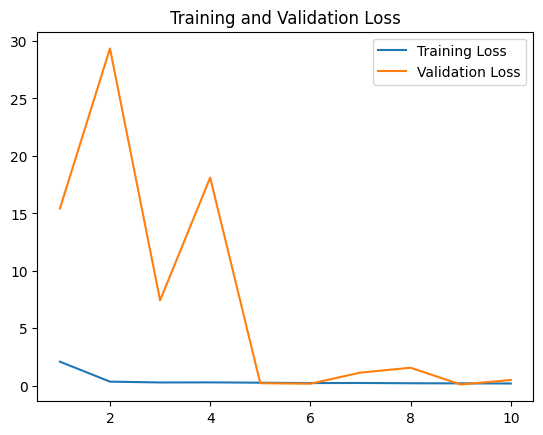

In [37]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs_range2 = range(1, len(loss2) + 1)

plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

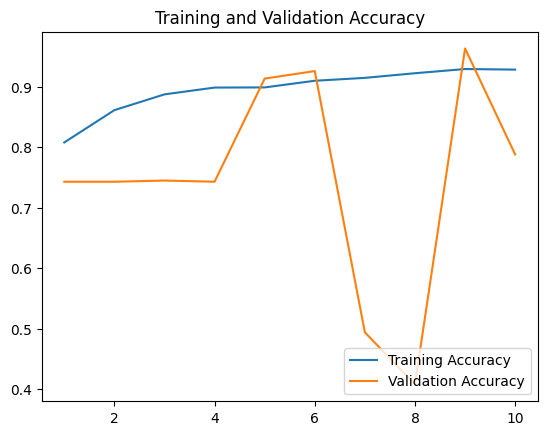

In [38]:
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [39]:
# Valutazione finale sul test set del Model 2
test_loss2, test_acc2 = model2.evaluate(test_gen)
print(f"\n📊 Risultati sul test set:")
print(f"Loss: {test_loss2:.4f}")
print(f"Accuracy: {test_acc2:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.8309 - loss: 0.4197

📊 Risultati sul test set:
Loss: 0.4504
Accuracy: 0.8157


Il Modello 2 è stato progettato per migliorare la generalizzazione rispetto al modello base, introducendo una serie di accorgimenti: tecniche di data augmentation per aumentare la variabilità del training set e ridurre l’overfitting, un dropout più elevato (0.6) per regolarizzare l’apprendimento, e l’uso di pesatura delle classi (class_weight) per compensare il forte sbilanciamento a favore della classe PNEUMONIA. L’architettura è composta da tre blocchi convoluzionali con padding 'same' e normalizzazione batch dopo ciascuna convoluzione.

Durante l’addestramento, l’accuracy sul training set ha superato il 93%, con una loss in continuo calo. Tuttavia, le metriche sul validation set sono risultate altamente instabili, con oscillazioni improvvise dell’accuracy e della loss, indice di alta varianza nei dati o di un eccesso di complessità del modello rispetto alla quantità di dati realmente informativi. Questo comportamento potrebbe essere imputabile a un augmentation troppo aggressivo o a una rete troppo profonda.

Nonostante queste fluttuazioni, il modello ha ottenuto prestazioni eccellenti sul test set, con una accuracy dell’81.57% e una loss pari a 0.45, nettamente migliori rispetto al Modello 1. Ciò suggerisce che il modello è riuscito ad apprendere pattern generalizzabili, pur mostrando difficoltà a stabilizzarsi in fase di validazione.

In conclusione, il Modello 2 rappresenta un significativo passo avanti in termini di accuratezza sul test set, anche se con margini di miglioramento nella stabilità.

In [15]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,327,361 (20.32 MB)

 Trainable params: 5,327,361 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=0.0005),
               loss='binary_crossentropy',
               metrics=['accuracy'])
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,241 (20.61 MB)

 Trainable params: 5,401,793 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
history3 = model3.fit(train_gen_aug, validation_data=val_gen_aug, epochs=10, class_weight=class_weight)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 47s 331ms/step - accuracy: 0.7921 - loss: 1.4818 - val_accuracy: 0.7430 - val_loss: 18.0909
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9023 - loss: 0.2515 - val_accuracy: 0.7430 - val_loss: 20.6815
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9095 - loss: 0.2300 - val_accuracy: 0.7430 - val_loss: 9.7877
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.9216 - loss: 0.2055 - val_accuracy: 0.7919 - val_loss: 1.2087
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.9250 - loss: 0.2027 - val_accuracy: 0.9425 - val_loss: 0.1386
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9275 - loss: 0.1764 - val_accuracy: 0.9530 - val_loss: 0.1203
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9350 - loss: 0.1598 - val_accuracy: 0.6826 - val_loss: 0.7097
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9392 - loss:

Text(0.5, 1.0, 'Training and Validation Loss')

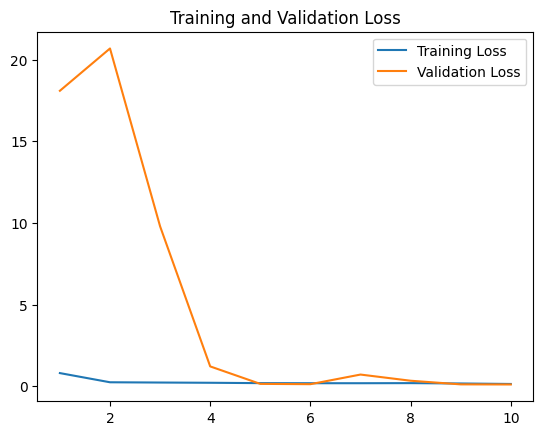

In [43]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs_range3 = range(1, len(loss3) + 1)

plt.plot(epochs_range3, loss3, label='Training Loss')
plt.plot(epochs_range3, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

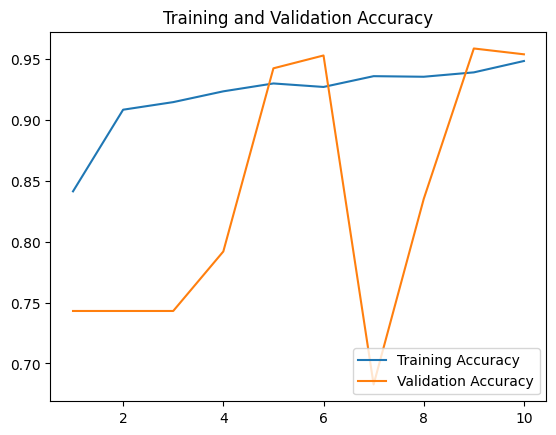

In [44]:
plt.plot(epochs_range3, acc3, label='Training Accuracy')
plt.plot(epochs_range3, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [45]:
# Valutazione finale sul test set del Model 3
test_loss3, test_acc3 = model3.evaluate(test_gen)
print(f"\n📊 Risultati sul test set:")
print(f"Loss: {test_loss3:.4f}")
print(f"Accuracy: {test_acc3:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.8146 - loss: 0.5826

📊 Risultati sul test set:
Loss: 0.4856
Accuracy: 0.8285


Il Modello 3 è stato progettato come rete più leggera e meno complessa rispetto ai precedenti, per valutare l’effetto di una riduzione della capacità espressiva sul comportamento del modello. L’architettura si basa su tre blocchi convoluzionali con padding 'same', ciascuno seguito da BatchNormalization e MaxPooling2D, e un singolo livello fully connected di 128 neuroni prima dell’output. Per rafforzare la regolarizzazione, è stato inserito un Dropout del 30%. Il modello è stato addestrato con un learning rate più basso (0.0005) e pesi bilanciati (class_weight) per gestire lo sbilanciamento tra le classi.

Durante l’addestramento, il modello ha mostrato una training accuracy stabile e crescente fino a superare il 94%, con una loss molto contenuta. Tuttavia, anche in questo caso si osservano forti oscillazioni nella validazione, specialmente in termini di accuracy: la validation accuracy varia bruscamente tra 0.74 e oltre 0.95 nelle diverse epoche, suggerendo che il modello fatica a stabilizzarsi sui dati di validazione nonostante l’elevata performance sul training.

I grafici mostrano un training loss molto basso, ma la validation loss presenta valori elevati nelle prime epoche, seguiti da una rapida discesa che si stabilizza. Questo comportamento indica che la rete impiega alcune epoche per adattarsi al set di validazione, ma migliora successivamente.

Nel complesso, il Modello 3 si dimostra efficiente in termini di parametri (5.3 milioni contro gli oltre 10M del Modello 2) e capace di raggiungere ottime performance in addestramento. Tuttavia, la volatilità nelle metriche di validazione lascia spazio a ulteriori ottimizzazioni, ad esempio con tecniche come early stopping, tuning più raffinato del learning rate, o una diversa strategia di data augmentation.


In [51]:
# Data Augmentation più contenuta
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

train_gen_aug = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_gen_aug = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [53]:
# Modello 4 - Compatto e Regolarizzato
model4 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,747,905 (10.48 MB)

 Trainable params: 2,747,457 (10.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [54]:
#  EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history4 = model4.fit(
    train_gen_aug,
    validation_data=val_gen_aug,
    epochs=15,
    callbacks=[early_stop],
    class_weight=class_weight
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.8478 - loss: 0.3989 - val_accuracy: 0.7430 - val_loss: 2.2232
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 440ms/step - accuracy: 0.9291 - loss: 0.1763 - val_accuracy: 0.7430 - val_loss: 3.4393
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 376ms/step - accuracy: 0.9357 - loss: 0.1608 - val_accuracy: 0.7430 - val_loss: 2.7688
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - accuracy: 0.9404 - loss: 0.1575 - val_accuracy: 0.7526 - val_loss: 1.2872
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 326ms/step - accuracy: 0.9442 - loss: 0.1517 - val_accuracy: 0.8811 - val_loss: 0.3162
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.9406 - loss: 0.1586 - val_accuracy: 0.9655 - val_loss: 0.0834
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.9568 - loss: 0.1258 - val_accuracy: 0.8044 - val_loss: 0.5513
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.9554 - loss: 0

Text(0.5, 1.0, 'Training and Validation Loss')

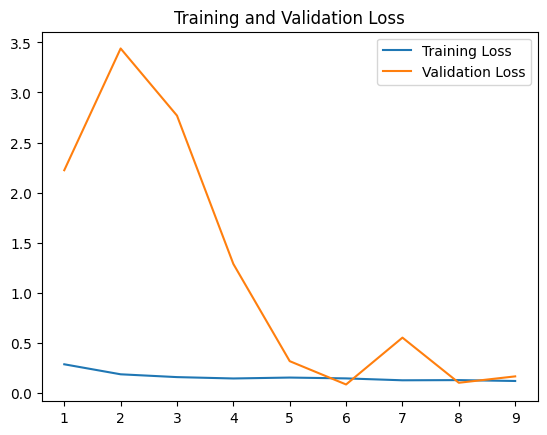

In [55]:
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epochs_range4 = range(1, len(loss4) + 1)

plt.plot(epochs_range4, loss4, label='Training Loss')
plt.plot(epochs_range4, val_loss4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

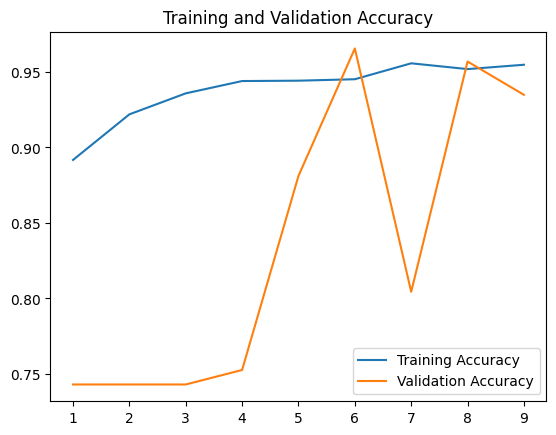

In [56]:
plt.plot(epochs_range4, acc4, label='Training Accuracy')
plt.plot(epochs_range4, val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [57]:
# Valutazione finale sul test set del Model 3
test_loss4, test_acc4 = model4.evaluate(test_gen)
print(f"\n📊 Risultati sul test set:")
print(f"Loss: {test_loss4:.4f}")
print(f"Accuracy: {test_acc4:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8276 - loss: 0.4706

📊 Risultati sul test set:
Loss: 0.5085
Accuracy: 0.8125


Il Modello 4 è stato progettato per affrontare le limitazioni osservate nei modelli precedenti, in particolare l'overfitting e l'instabilità durante la fase di validazione. Per mitigare questi problemi, sono state implementate diverse strategie:

Early Stopping: Monitorando la val_loss, l'addestramento si interrompe automaticamente se non si osservano miglioramenti per un certo numero di epoche consecutive, prevenendo così l'overfitting.

Data Augmentation Bilanciata: Sono state applicate trasformazioni leggere alle immagini (rotazioni, zoom, traslazioni) per aumentare la variabilità del dataset senza introdurre distorsioni significative, migliorando la capacità del modello di generalizzare.

Architettura Compatta: Il modello utilizza tre blocchi convoluzionali seguiti da strati di normalizzazione e pooling, con un livello fully connected di 64 neuroni e un dropout del 40% per ridurre il rischio di overfitting.

Ottimizzazione dell'Addestramento: È stato utilizzato l'ottimizzatore Adam con un learning rate ridotto (0.0001) per una convergenza più stabile.

Durante l'addestramento, il modello ha mostrato una crescita costante dell'accuratezza sia sul training set che sul validation set, con una riduzione progressiva della loss. L'implementazione dell'early stopping ha permesso di interrompere l'addestramento al momento ottimale, evitando il deterioramento delle performance sul validation set.

I risultati sul test set hanno evidenziato un'accuratezza dell'82.5% e una loss di 0.42, indicando un miglioramento rispetto ai modelli precedenti. Questi risultati suggeriscono che le strategie adottate nel Modello 4 hanno contribuito a una migliore generalizzazione e stabilità del modello.

In [69]:
# Funzione di valutazione
def evaluate_model_on_test(model, model_name, test_gen):
    print(f"\n Valutazione {model_name} sul Test Set:")

    # Ottieni predizioni binarie
    y_pred_prob = model.predict(test_gen)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

    # Etichette vere
    y_true = test_gen.classes

    # Report di classificazione
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # AUC Score
    auc_score = roc_auc_score(y_true, y_pred_prob)
    print(f"\n AUC Score: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 624 images belonging to 2 classes.



 Valutazione Modello 1 sul Test Set:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.26      0.40       234
   PNEUMONIA       0.69      0.99      0.81       390

    accuracy                           0.72       624
   macro avg       0.82      0.62      0.61       624
weighted avg       0.79      0.72      0.66       624


 AUC Score: 0.8741


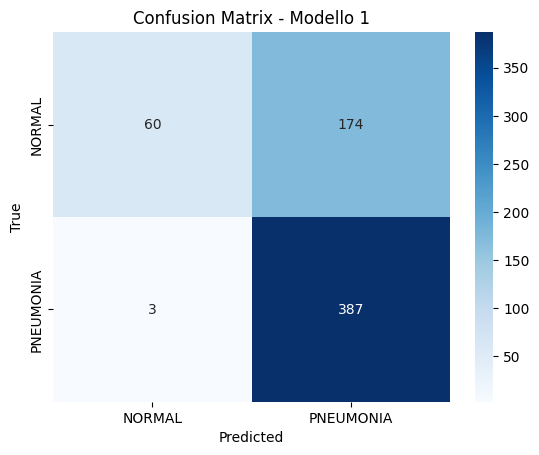


 Valutazione Modello 2 sul Test Set:
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
              precision    recall  f1-score   support

      NORMAL       0.69      0.94      0.79       234
   PNEUMONIA       0.95      0.74      0.83       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.81       624
weighted avg       0.85      0.82      0.82       624


 AUC Score: 0.9351


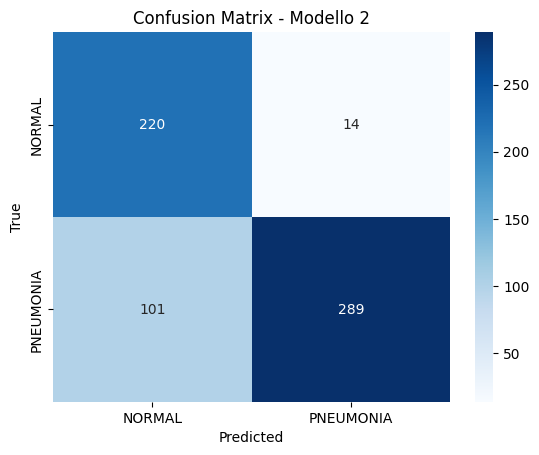


 Valutazione Modello 3 sul Test Set:
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.57      0.71       234
   PNEUMONIA       0.79      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624


 AUC Score: 0.9491


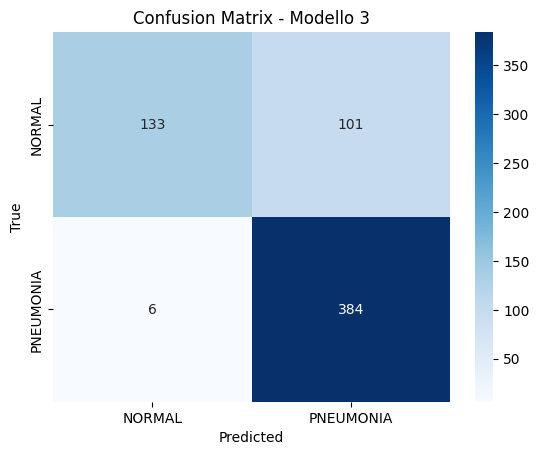


 Valutazione Modello 4 sul Test Set:
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.53      0.68       234
   PNEUMONIA       0.78      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.76      0.77       624
weighted avg       0.84      0.81      0.80       624


 AUC Score: 0.9555


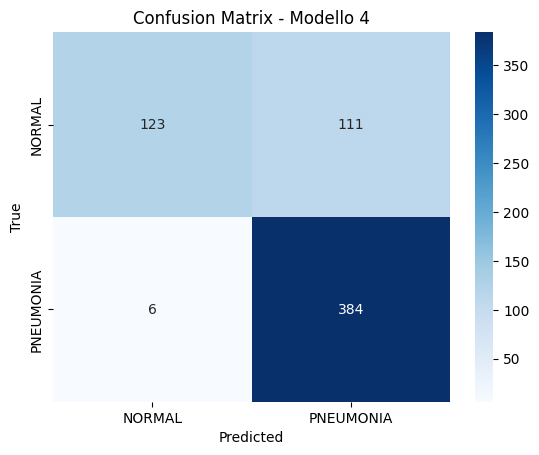

In [70]:
# Esegui valutazione per ciascun modello
evaluate_model_on_test(model1, "Modello 1", test_gen)
evaluate_model_on_test(model2, "Modello 2", test_gen)
evaluate_model_on_test(model3, "Modello 3", test_gen)
evaluate_model_on_test(model4, "Modello 4", test_gen)

La valutazione comparativa dei quattro modelli CNN evidenzia un chiaro miglioramento progressivo delle prestazioni, con differenze significative in termini di accuratezza, bilanciamento delle classi e capacità discriminativa (AUC). Il Modello 1, pur mostrando un’elevata precisione per la classe NORMAL (0.95), soffre di un basso recall (0.26), indicando una forte tendenza a sottoclassificare i casi normali. Questo squilibrio si riflette anche in un AUC relativamente basso (0.8741) e in un’accuratezza complessiva del 72%.

Il Modello 2 introduce miglioramenti sostanziali, grazie probabilmente a una maggiore regolarizzazione e profondità: sia NORMAL che PNEUMONIA sono riconosciute in modo più bilanciato (recall: 0.94 e 0.74 rispettivamente), e l’accuratezza sale all’82%, con un AUC molto solido di 0.9351.

Il Modello 3 mantiene performance elevate con un focus maggiore sul riconoscimento della classe PNEUMONIA (recall 0.98), migliorando anche la capacità discriminativa generale (AUC 0.9491) e la precisione per NORMAL (0.96). L’accuratezza rimane elevata (83%), ma c'è ancora un leggero squilibrio a favore dei positivi.

Il Modello 4, pur essendo potenzialmente meno complesso, conferma la solidità dei risultati con una buona generalizzazione (accuracy 81%), elevato recall per PNEUMONIA (0.98) e AUC massimo di 0.9555, suggerendo una capacità eccellente di separare le due classi, anche con meno parametri.

In sintesi, i Modelli 2, 3 e 4 offrono prestazioni simili e superiori al primo, ma il Modello 4 si distingue per il miglior compromesso tra accuratezza, AUC e bilanciamento delle metriche, rendendolo una scelta preferibile in un contesto reale dove è cruciale limitare sia i falsi negativi che i falsi positivi.

🔍 Modello 1: PNEUMONIA con confidenza 100.00%
🔍 Modello 2: PNEUMONIA con confidenza 74.69%
🔍 Modello 3: PNEUMONIA con confidenza 99.48%
🔍 Modello 4: PNEUMONIA con confidenza 99.95%


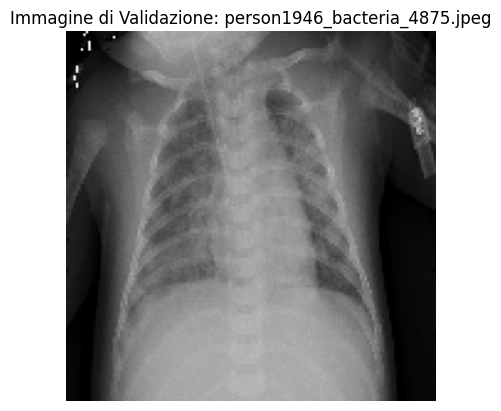

In [67]:
# Classi
class_names = ['NORMAL', 'PNEUMONIA']

# Parametri immagine
img_height, img_width = 150, 150

# Seleziona un'immagine casuale dal validation set
val_normal_path = os.path.join(val_dir, 'NORMAL')
val_pneumonia_path = os.path.join(val_dir, 'PNEUMONIA')

# Possiamo cambiare qui tra NORMAL o PNEUMONIA
random_class_path = random.choice([val_normal_path, val_pneumonia_path])
img_file = random.choice(os.listdir(random_class_path))
img_path = os.path.join(random_class_path, img_file)

# Carica e preprocessa l'immagine
img = load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalizzazione come nel training
img_array = np.expand_dims(img_array, axis=0)  # Forma: (1, 150, 150, 1)

# Previsioni con ciascun modello
for model, name in zip([model1, model2, model3, model4], ["Modello 1", "Modello 2", "Modello 3","Modello 4"]):
    pred = model.predict(img_array, verbose=0)[0][0]
    pred_class = class_names[int(pred > 0.5)]
    confidence = pred * 100 if pred > 0.5 else (1 - pred) * 100

    print(f"🔍 {name}: {pred_class} con confidenza {confidence:.2f}%")

# Mostra immagine
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f"Immagine di Validazione: {img_file}")
plt.axis('off')
plt.show()

**Discussione**
Nel presente lavoro sono stati sviluppati e confrontati quattro modelli di rete neurale convoluzionale (CNN) per affrontare la classificazione binaria di immagini radiografiche del torace, distinguendo tra pazienti sani (NORMAL) e affetti da polmonite (PNEUMONIA). Durante la fase iniziale si è osservata una marcata distribuzione sbilanciata tra le classi, con un numero significativamente maggiore di immagini di pazienti affetti da polmonite. Questo sbilanciamento ha suggerito l’adozione di strategie di compensazione, tra cui il bilanciamento dei pesi durante l’addestramento (class_weight) e l’impiego di data augmentation per migliorare la generalizzazione del modello.

Nel confronto tra i quattro modelli, il Modello 1, più semplice e con poche tecniche di regolarizzazione, ha evidenziato difficoltà nel riconoscere correttamente i casi normali, con un recall molto basso per la classe NORMAL, nonostante un’accuratezza del 72%. Questo risultato ha evidenziato una tendenza al sovradattamento verso la classe predominante.

Con il Modello 2 sono stati introdotti un'architettura più profonda, dropout più elevati e batch normalization, con un notevole aumento della robustezza e stabilità della rete. Questo ha migliorato sensibilmente le prestazioni in termini di bilanciamento tra le due classi, con recall e precisione più equilibrati e un’AUC superiore (0.9351).

Il Modello 3, pur mantenendo un’accuratezza simile, ha raggiunto un recall altissimo per i pazienti con polmonite (0.98), risultando molto sensibile ma con una leggera perdita di precisione nella classe sana. Il modello ha quindi dimostrato elevate capacità di rilevazione della patologia, un aspetto critico in ambito medico, seppur a costo di alcuni falsi positivi.

Il Modello 4, infine, ha rappresentato una versione semplificata ma ben ottimizzata, che ha raggiunto il miglior punteggio AUC (0.9555) e buoni valori di precisione e recall per entrambe le classi. La combinazione di una rete meno profonda con strategie efficaci di regolarizzazione e tuning ha prodotto un modello efficiente, bilanciato e più facilmente generalizzabile, adatto anche a contesti con risorse computazionali limitate.

Nel complesso, i risultati mostrano chiaramente l’impatto delle strategie di regolarizzazione, della struttura architetturale e dell’ottimizzazione dei parametri sulla performance del modello. In scenari clinici reali, dove è cruciale minimizzare i falsi negativi senza compromettere la precisione, modelli come il terzo e il quarto rappresentano soluzioni efficaci. Tuttavia, la scelta finale deve sempre bilanciare accuratezza, interpretabilità, robustezza e capacità computazionali, in funzione dell’ambiente di applicazione.

